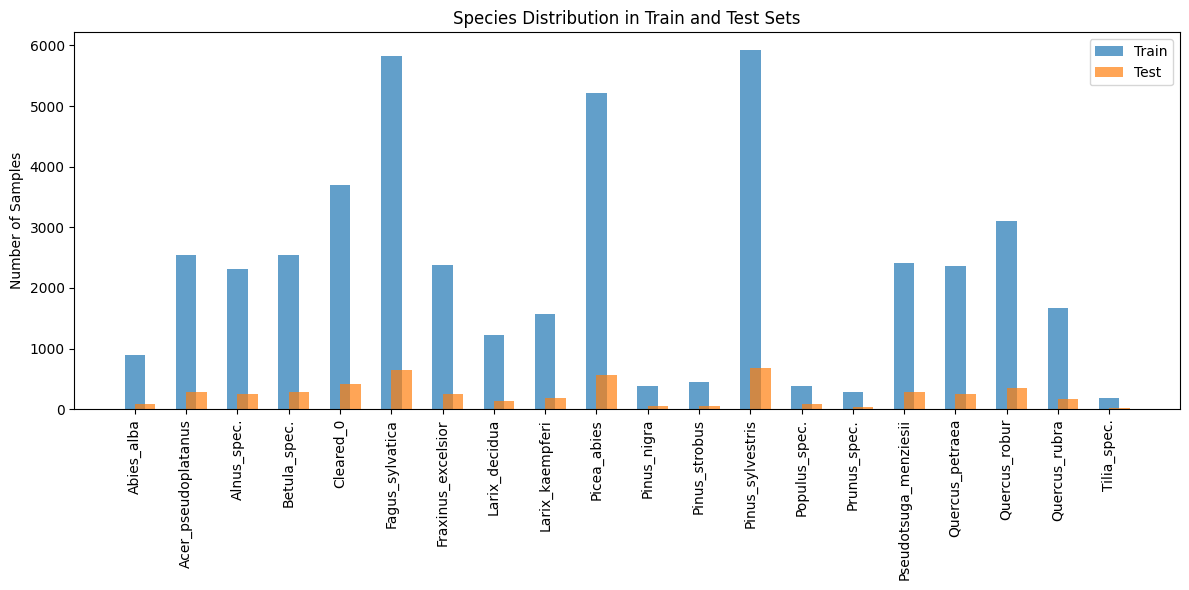

In [6]:
import os
import matplotlib.pyplot as plt
from collections import Counter

# Load file paths
train_files = [line.strip() for line in open("/Users/user/Downloads/DLF/train_filenames.lst")]
test_files = [line.strip() for line in open("/Users/user/Downloads/DLF/test_filenames.lst")]

# Extract species names from file names
def extract_species(filename):
    parts = filename.split('_')
    return f"{parts[0]}_{parts[1]}"  # Join genus and species

train_species = [extract_species(f) for f in train_files]
test_species = [extract_species(f) for f in test_files]


# Count occurrences of each species
train_counts = Counter(train_species)
test_counts = Counter(test_species)

# Get sorted species names
species_list = sorted(set(train_species + test_species))
train_values = [train_counts[species] for species in species_list]
test_values = [test_counts[species] for species in species_list]

# Plot distribution
fig, ax = plt.subplots(figsize=(12, 6))
x = range(len(species_list))
ax.bar(x, train_values, width=0.4, label="Train", align='center', alpha=0.7)
ax.bar(x, test_values, width=0.4, label="Test", align='edge', alpha=0.7)
ax.set_xticks(x)
ax.set_xticklabels(species_list, rotation=90)
ax.set_ylabel("Number of Samples")
ax.set_title("Species Distribution in Train and Test Sets")
ax.legend()
plt.tight_layout()
plt.show()


In [22]:
import rasterio
from torchvision.transforms import ToTensor
import torch

example_tif = "/Users/user/Downloads/DLF/s2/60m/Abies_alba_0_2545_WEFL_NLF.tif"
with rasterio.open(example_tif) as src:
    img = src.read()  # shape: (bands, height, width)
    
    print("Shape(band, height, width):", img.shape)
    print("Data type:", img.dtype)
    print("Min/Max value:", img.min(), img.max())
    # PyTorch example
    img_tensor = torch.from_numpy(img).float()  # (12, 20, 20) for 200m patches
    print(img_tensor)
##below does the same thing converting to tensor     
image = rasterio.open(example_tif)
image = image.read()
image = ToTensor()(image)
#print(image)

Shape(band, height, width): (12, 6, 6)
Data type: uint16
Min/Max value: 61 2444
tensor([[[  97.,   93.,   86.,   65.,   90.,  101.],
         [  93.,  104.,   91.,   61.,   85.,   93.],
         [ 124.,  108.,  104.,   65.,   84.,   83.],
         [ 114.,   82.,   93.,   91.,   93.,   75.],
         [  79.,   77.,   91.,   93.,  106.,   93.],
         [ 129.,  108.,  119.,  132.,  141.,  119.]],

        [[ 176.,  199.,  199.,  189.,  220.,  220.],
         [ 222.,  212.,  186.,  187.,  214.,  207.],
         [ 268.,  249.,  204.,  185.,  173.,  147.],
         [ 233.,  224.,  203.,  194.,  191.,  187.],
         [ 172.,  172.,  197.,  207.,  216.,  226.],
         [ 246.,  263.,  301.,  311.,  313.,  309.]],

        [[  89.,   79.,   87.,   73.,  104.,   98.],
         [ 100.,   92.,  109.,   87.,  118.,   97.],
         [ 168.,  145.,  127.,   90.,  104.,   90.],
         [ 149.,  123.,  130.,  126.,  147.,  126.],
         [ 133.,   88.,   99.,  120.,  147.,  131.],
         [ 159.

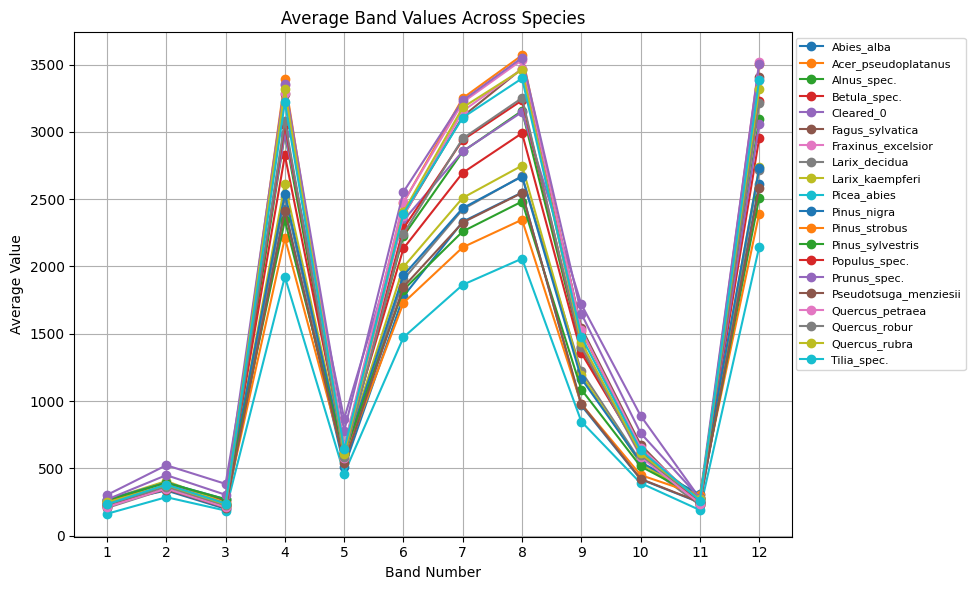

In [25]:
import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from collections import defaultdict

# Define the base directory where images are stored
base_dir = "/Users/user/Downloads/DLF/s2/60m"  # Change this to the correct folder
# Load file paths
train_files = [line.strip() for line in open("/Users/user/Downloads/DLF/train_filenames.lst")]

# Extract species names from file names
def extract_species(filename):
    parts = filename.split('_')
    return f"{parts[0]}_{parts[1]}"  # Join genus and species

# Group images by species
species_band_sums = defaultdict(lambda: np.zeros(12))  # Store sum of band values
species_counts = defaultdict(int)  # Count images per species

for filename in train_files:
    species = extract_species(filename)
    img_path = os.path.join(base_dir, filename)  # Prepend the correct directory path

    if not os.path.exists(img_path):
        print(f"Skipping {filename} - File not found in {base_dir}")
        continue  # Skip if file does not exist

    try:
        with rasterio.open(img_path) as src:
            img = src.read().astype(np.float32)  # Shape: (12, H, W)
            avg_band_values = img.mean(axis=(1, 2))  # Compute avg per band

        species_band_sums[species] += avg_band_values
        species_counts[species] += 1
    except Exception as e:
        print(f"Skipping {filename} due to error: {e}")

# Compute the average band values per species
species_avg_bands = {species: species_band_sums[species] / species_counts[species]
                     for species in species_counts if species_counts[species] > 0}

# Plot all species on one graph
plt.figure(figsize=(10, 6))

for species, avg_bands in species_avg_bands.items():
    plt.plot(range(1, 13), avg_bands, marker='o', linestyle='-', label=species)

plt.xlabel("Band Number")
plt.ylabel("Average Value")
plt.title("Average Band Values Across Species")
plt.xticks(range(1, 13))
plt.legend(loc="upper right", fontsize=8, bbox_to_anchor=(1.25, 1))
plt.grid(True)
plt.tight_layout()
plt.show()
